# Actor-Critic Training for Attack-Defense Tree Multi-Agent Environment

## Training Process
1. Environment setup and configuration
2. Agent initialization with neural networks
3. Multi-agent training loop with episode collection
4. Performance monitoring and visualization
5. Model saving and evaluation

In [1]:
# Import Required Libraries
import numpy as np
import torch
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
import sys
from tqdm.notebook import tqdm

# Add parent directory to path to find the core module
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

# Import our custom modules
from core.adt_env import AttackDefenseTreeMultiAgentEnv
from core.adt_actor_critic import ADTAgent, TrainingMetrics

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Consistent random seed for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
# set device
device_name = "cpu" # Force CPU usage for small models
device = torch.device(device_name)
print(f"Using device: {device}")

PyTorch version: 2.7.1+cu126
CUDA available: True
Using device: cpu


/home/valerio/PANACEA/rl/core/adt_env.py:260: SyntaxWarning: "is not" with 'str' literal. Did you mean "!="?
  if self.goal_reached and action_name is not "":


## Environment Setup and Configuration

First, let's create the multi-agent environment and examine its properties.

In [2]:
# Create the environment (using clean environment without problematic wrappers)
print("🌍 Setting up ADT Multi-Agent Environment...")

# Create environment directly without wrappers to avoid reset issues
env_name = "adt_nuovo_env"
env_file = "envs/"+env_name+".json"
env = AttackDefenseTreeMultiAgentEnv(env_file, render_mode=None)
print("✅ Environment created successfully (clean, without wrappers)!")

# Environment information
print(f"\n📊 Environment Information:")
print(f"Agents: {env.possible_agents}")
print(f"Action spaces: {env.action_spaces}")
print(f"Observation spaces: {env.observation_spaces}")

# Reset to get initial observations
obs, info = env.reset(seed=42)
print(f"\n🔍 Initial observation shapes:")
for agent, observation in obs.items():
    print(f"  {agent}: {observation.shape}")
print("✅ Environment reset working properly!")


# Get state and action dimensions
state_size = env.observation_spaces['attacker'].shape[0]
attacker_action_size = env.action_spaces['attacker'].n
defender_action_size = env.action_spaces['defender'].n

print(f"\n🧠 Network Dimensions:")
print(f"State size: {state_size}")
print(f"Attacker actions: {attacker_action_size}")
print(f"Defender actions: {defender_action_size}")

# Test a quick episode iteration
print(f"\n⚙️  Testing environment iteration...")
try:
    agent_count = 0
    for agent_name in env.agent_iter():
        agent_count += 1
        if agent_count > 2:  # Just test first 2 iterations
            break
        obs, reward, term, trunc, info = env.last()
        print(f"  Agent {agent_name}: obs shape {obs.shape}")
        env.step(0)  # Take a dummy action
    print("✅ Environment iteration working!")
except Exception as e:
    print(f"⚠️  Iteration warning: {e}")

🌍 Setting up ADT Multi-Agent Environment...
✅ Environment created successfully (clean, without wrappers)!

📊 Environment Information:
Agents: ['attacker', 'defender']
Action spaces: {'attacker': Discrete(6), 'defender': Discrete(7)}
Observation spaces: {'attacker': Box([0 0 0 0 0 0 0 1 1 1 1 1 1], [1 1 2 2 2 2 2 2 2 2 2 2 2], (13,), int32), 'defender': Box([0 0 0 0 0 0 0 1 1 1 1 1 1], [1 1 2 2 2 2 2 2 2 2 2 2 2], (13,), int32)}

🔍 Initial observation shapes:
  attacker: (13,)
  defender: (13,)
✅ Environment reset working properly!

🧠 Network Dimensions:
State size: 13
Attacker actions: 6
Defender actions: 7

⚙️  Testing environment iteration...
  Agent attacker: obs shape (13,)
  Agent defender: obs shape (13,)
✅ Environment iteration working!


## Agent Initialization

Create the actor-critic agents for both attacker and defender with appropriate neural network architectures.

In [3]:
# Training hyperparameters
LEARNING_RATE = 3e-4 # Learning rate for the optimizer
GAMMA = 0.99 # Discount factor
HIDDEN_SIZE = 128 # Size of hidden layers in the neural networks
MAX_EPISODES = 10_000
UPDATE_FREQUENCY = 10  # Update policy every N episodes
PRINT_FREQUENCY = 1000  # Print stats every N episodes

# Epsilon exploration parameters
EPSILON_START = 0.99  # Starting epsilon for exploration
EPSILON_END = 0.01   # Final epsilon for exploration
EPSILON_DECAY = 5000  # Number of steps for epsilon decay

print("🤖 Initializing Actor-Critic Agents with Epsilon Exploration...")

# Create agents
attacker_agent = ADTAgent(
    state_size=state_size,
    action_size=attacker_action_size,
    agent_name='attacker',
    lr=LEARNING_RATE,
    gamma=GAMMA,
    hidden_size=HIDDEN_SIZE,
    device=device_name,
    epsilon_start=EPSILON_START,
    epsilon_end=EPSILON_END,
    epsilon_decay=EPSILON_DECAY
)

defender_agent = ADTAgent(
    state_size=state_size,
    action_size=defender_action_size,
    agent_name='defender',
    lr=LEARNING_RATE,
    gamma=GAMMA,
    hidden_size=HIDDEN_SIZE,
    device=device_name,
    epsilon_start=EPSILON_START,
    epsilon_end=EPSILON_END,
    epsilon_decay=EPSILON_DECAY
)

print(f"✅ Agents initialized with epsilon exploration!")
print(f"   Epsilon start: {EPSILON_START}")
print(f"   Epsilon end: {EPSILON_END}")
print(f"   Epsilon decay: {EPSILON_DECAY} steps")

# Initialize training metrics
metrics = TrainingMetrics()

print("📊 Model Summary:")
print("Attacker Agent:")
summary(attacker_agent.network, (state_size,), device=device_name)
print("Defender Agent:")
summary(defender_agent.network, (state_size,), device=device_name)

🤖 Initializing Actor-Critic Agents with Epsilon Exploration...
✅ Agents initialized with epsilon exploration!
   Epsilon start: 0.99
   Epsilon end: 0.01
   Epsilon decay: 5000 steps
📊 Model Summary:
Attacker Agent:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]           1,792
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 64]           8,256
              ReLU-6                   [-1, 64]               0
            Linear-7                    [-1, 6]             390
            Linear-8                   [-1, 64]           8,256
              ReLU-9                   [-1, 64]               0
           Linear-10                    [-1, 1]              65
Total params: 3

## Training Helper Functions

Define utility functions for the training process.

In [4]:
def run_episode(env, attacker_agent, defender_agent, episode_num, max_steps=50):
    """
    Run a single episode and collect experience for both agents.
    
    Returns:
        dict: Episode statistics including rewards, length, and winner
    """

    obs, info = env.reset()

    episode_data = {
        'attacker_reward': 0,
        'defender_reward': 0,
        'length': 0,
        'winner': None,
        'goal_achieved': False
    }
    
    step_count = 0
    
    # Run episode
    for agent_name in env.agent_iter():
        if step_count >= max_steps:
            break
            
        observation, reward, termination, truncation, info = env.last()
        
        # Update rewards
        episode_data[f'{agent_name}_reward'] += reward
        
        if termination or truncation:
            # Store final transition
            if agent_name == 'attacker':
                attacker_agent.store_transition(
                    state=observation,
                    action=0,  # Dummy action for terminal state
                    reward=reward,
                    log_prob=torch.tensor(0.0),
                    value=torch.tensor(0.0),
                    done=True
                )
            else:
                defender_agent.store_transition(
                    state=observation,
                    action=0,  # Dummy action for terminal state
                    reward=reward,
                    log_prob=torch.tensor(0.0),
                    value=torch.tensor(0.0),
                    done=True
                )
            break
        
        step_count += 1
        episode_data['length'] = step_count
        
        # Get available actions
        available_actions = env.get_available_actions(agent_name)
        
        
        # Get action from appropriate agent
        if agent_name == 'attacker':
            action, log_prob, value, _ = attacker_agent.get_action(observation.astype(np.float32), available_actions)
            attacker_agent.store_transition(observation, action, reward, log_prob, value, False)
        else:
            action, log_prob, value, _ = defender_agent.get_action(observation.astype(np.float32), available_actions)
            defender_agent.store_transition(observation, action, reward, log_prob, value, False)
        
        # Take action
        env.step(action)

    episode_data['goal_achieved'] = env.goal_reached  # Check if goal was achieved
    if episode_data['goal_achieved']:
        episode_data['winner'] = 'attacker'  # Attacker achieved goal
    else:
        episode_data['winner'] = 'defender'  # Defender prevented goal
    
    return episode_data


def print_training_stats(episode, metrics, start_time):
    """Print training statistics."""
    current_time = time.time()
    elapsed_time = current_time - start_time
    
    # Get recent statistics
    recent_stats = metrics.get_recent_stats(window=100)
    
    print(f"\n{'='*80}")
    print(f"EPISODE {episode:4d} | Time: {elapsed_time/60:.1f}m")
    print(f"{'='*80}")
    
    if recent_stats:
        print(f"📊 Last 100 Episodes:")
        print(f"   🔥 Avg Attacker Reward: {recent_stats['avg_attacker_reward']:8.2f}")
        print(f"   🛡️  Avg Defender Reward: {recent_stats['avg_defender_reward']:8.2f}")
        print(f"   📏 Avg Episode Length:  {recent_stats['avg_episode_length']:8.2f} steps")
        print(f"   🏆 Attacker Win Rate:   {recent_stats['attacker_win_rate']:8.2%}")
        print(f"   🏆 Defender Win Rate:   {recent_stats['defender_win_rate']:8.2%}")
    
    # Show recent losses if available
    if len(metrics.attacker_losses['total']) > 0:
        recent_att_loss = np.mean(metrics.attacker_losses['total'][-10:])
        recent_def_loss = np.mean(metrics.defender_losses['total'][-10:])
        print(f"   📉 Recent Attacker Loss: {recent_att_loss:8.4f}")
        print(f"   📉 Recent Defender Loss: {recent_def_loss:8.4f}")


# Create directories for saving models and metrics
os.makedirs('trained_models', exist_ok=True)
os.makedirs('training_logs', exist_ok=True)

print("✅ Training helper functions defined!")
print("📁 Directories created for saving models and logs")

✅ Training helper functions defined!
📁 Directories created for saving models and logs


## Main Training Loop

Execute the main training loop with experience collection and policy updates.

In [5]:
# Main Training Loop
print("🚀 Starting Actor-Critic Training!")
print("="*80)

start_time = time.time()
best_combined_reward = float('-inf')

for episode in tqdm(range(1, MAX_EPISODES + 1)):
    # Run episode and collect experience
    episode_data = run_episode(env, attacker_agent, defender_agent, episode)
    
    # Log episode data
    metrics.log_episode(episode_data)
    
    # Update policies periodically
    if episode % UPDATE_FREQUENCY == 0:
        # Update attacker policy
        att_losses = attacker_agent.update_policy()
        if att_losses:
            metrics.log_losses('attacker', att_losses)
        
        # Update defender policy
        def_losses = defender_agent.update_policy()
        if def_losses:
            metrics.log_losses('defender', def_losses)
    
    # Print statistics
    if episode % PRINT_FREQUENCY == 0:
        print_training_stats(episode, metrics, start_time)

print(f"\n💾 Saving final metrics...")
metrics.save_metrics(f'training_logs/{env_name}_training_metrics.pkl')

total_time = time.time() - start_time
print(f"✅ Training completed in {total_time/60:.1f} minutes!")
print(f"📊 Total episodes: {len(metrics.episode_lengths)}")

🚀 Starting Actor-Critic Training!


  0%|          | 0/10000 [00:00<?, ?it/s]


EPISODE 1000 | Time: 0.1m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward:  -127.60
   🛡️  Avg Defender Reward:  -710.40
   📏 Avg Episode Length:      5.48 steps
   🏆 Attacker Win Rate:     61.00%
   🏆 Defender Win Rate:     39.00%
   📉 Recent Attacker Loss:   0.4866
   📉 Recent Defender Loss:   0.2615

EPISODE 2000 | Time: 0.2m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward:   -94.80
   🛡️  Avg Defender Reward:   127.95
   📏 Avg Episode Length:      5.12 steps
   🏆 Attacker Win Rate:     26.00%
   🏆 Defender Win Rate:     74.00%
   📉 Recent Attacker Loss:   0.4950
   📉 Recent Defender Loss:  -1.6062

EPISODE 3000 | Time: 0.3m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward:   -89.50
   🛡️  Avg Defender Reward:   262.70
   📏 Avg Episode Length:      5.12 steps
   🏆 Attacker Win Rate:     22.00%
   🏆 Defender Win Rate:     78.00%
   📉 Recent Attacker Loss:   0.4628
   📉 Recent Defender Loss:  -2.3260

EPISODE 4000 | Time: 0.4m
📊 Last 100 Episodes:
   🔥 Avg Attacker Reward:   -76.50
   🛡️  A

## Training Results Visualization

Analyze and visualize the training progress with comprehensive plots.

Training metrics loaded from training_logs/adt_nuovo_env_training_metrics.pkl
📊 Generating main training progress plot...


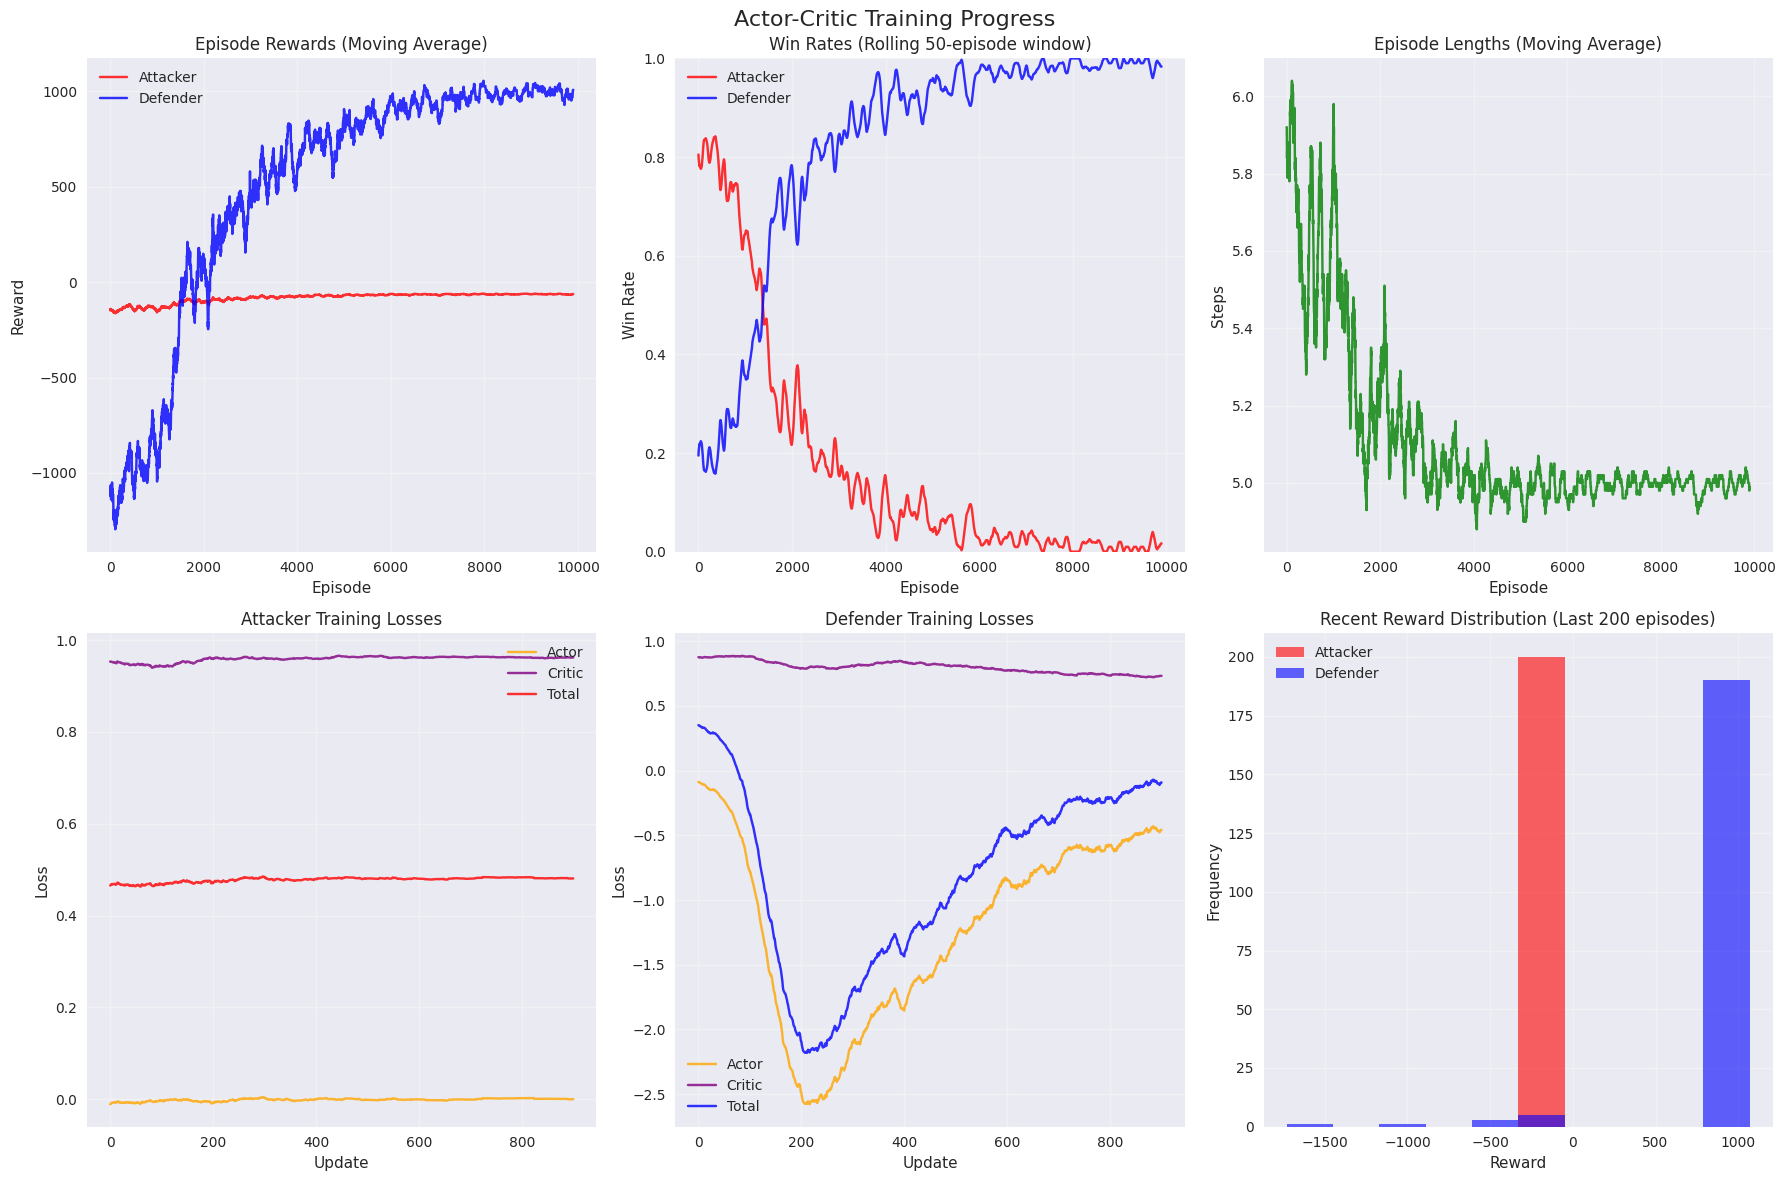


📈 FINAL TRAINING STATISTICS
Total Episodes Completed: 10000
Average Episode Length: 5.11 ± 0.70

🏆 FINAL PERFORMANCE (Last 200 episodes):
Attacker Win Rate: 1.00%
Defender Win Rate: 99.00%
Average Attacker Reward: -63.65
Average Defender Reward: 990.55
Average Episode Length: 5.00 steps

📋 COMPREHENSIVE TRAINING SUMMARY:
TRAINING SUMMARY
Total Episodes: 10000
Average Episode Length: 5.11 ± 0.70

REWARDS:
  Attacker - Mean: -81.791, Std: 51.119
  Defender - Mean: 488.986, Std: 989.964

WIN RATES:
  Attacker: 17.4%
  Defender: 82.6%

RECENT PERFORMANCE (Last 100 episodes):
  Attacker - Mean Reward: -62.200
  Defender - Mean Reward: 1007.900
  Attacker Win Rate: 1.0%
  Defender Win Rate: 99.0%


In [6]:
# Now use the separate plotting utility to generate visualizations
from plot_training_metrics import TrainingPlotter

# Create plotter instance
plotter = TrainingPlotter(f'training_logs/{env_name}_training_metrics.pkl')

# Generate comprehensive training progress plot
print("📊 Generating main training progress plot...")
plotter.plot_training_progress(
    save_path=f'training_logs/{env_name}_training_progress.png',
    show_plot=True
)

# Additional analysis using the metrics data directly
print(f"\n📈 FINAL TRAINING STATISTICS")
print(f"="*50)

total_episodes = len(metrics.episode_lengths)

# Overall statistics
print(f"Total Episodes Completed: {total_episodes}")
print(f"Average Episode Length: {np.mean(metrics.episode_lengths):.2f} ± {np.std(metrics.episode_lengths):.2f}")

# Final performance (last 200 episodes)
final_window = min(200, total_episodes)
final_stats = metrics.get_recent_stats(final_window)

print(f"\n🏆 FINAL PERFORMANCE (Last {final_window} episodes):")
print(f"Attacker Win Rate: {final_stats['attacker_win_rate']:.2%}")
print(f"Defender Win Rate: {final_stats['defender_win_rate']:.2%}")
print(f"Average Attacker Reward: {final_stats['avg_attacker_reward']:.2f}")
print(f"Average Defender Reward: {final_stats['avg_defender_reward']:.2f}")
print(f"Average Episode Length: {final_stats['avg_episode_length']:.2f} steps")

# Print comprehensive summary
print(f"\n📋 COMPREHENSIVE TRAINING SUMMARY:")
plotter.print_training_summary()

## Model Testing and Evaluation

Test the trained models with a few evaluation games to verify performance.

In [7]:
# Test the trained models
print("🧪 Testing Trained Models")
print("="*50)

def test_trained_models(n_test_games=10):
    """Test the trained models with deterministic policies."""
    print(f"Running {n_test_games} test games with trained models...")
    
    test_results = {
        'attacker_rewards': [],
        'defender_rewards': [],
        'episode_lengths': [],
        'winners': []
    }
    
    for game in range(n_test_games):
        # Handle environment reset with proper error handling
        obs, info = env.reset()
        
        game_rewards = {'attacker': 0, 'defender': 0}
        step_count = 0
        
        for agent_name in env.agent_iter():
            if step_count > 50:  # Max steps limit
                break
                
            observation, reward, termination, truncation, info = env.last()
            game_rewards[agent_name] += reward
            
            if termination or truncation:
                env.step(None)
                break
            
            step_count += 1
            # Get available actions
            available_actions = env.get_available_actions(agent_name)
            
            # Get deterministic action from trained agent
            if agent_name == 'attacker':
                action, _, _, _ = attacker_agent.get_action(observation, available_actions)
            else:
                action, _, _, _ = defender_agent.get_action(observation, available_actions)
            
            env.step(action)
        
        # Store results
        test_results['attacker_rewards'].append(game_rewards['attacker'])
        test_results['defender_rewards'].append(game_rewards['defender'])
        test_results['episode_lengths'].append(step_count)
        
        if env.goal_reached:
            test_results['winners'].append('attacker')
        else:
            test_results['winners'].append('defender')
        
        print(f"Game {game+1:2d}: Att {game_rewards['attacker']:6.1f} | "
              f"Def {game_rewards['defender']:6.1f} | "
              f"Length: {step_count:2d} | "
              f"Winner: {test_results['winners'][-1]}")
    
    return test_results

# Run test games
test_results = test_trained_models(10)

# Analyze test results
print(f"\n🎯 TEST RESULTS SUMMARY:")
print(f"="*30)
print(f"Average Attacker Reward: {np.mean(test_results['attacker_rewards']):.2f}")
print(f"Average Defender Reward: {np.mean(test_results['defender_rewards']):.2f}")
print(f"Average Episode Length: {np.mean(test_results['episode_lengths']):.2f} steps")

attacker_wins = test_results['winners'].count('attacker')
defender_wins = test_results['winners'].count('defender')  
ties = test_results['winners'].count('tie')

print(f"Attacker Wins: {attacker_wins}/{len(test_results['winners'])} ({attacker_wins/len(test_results['winners']):.1%})")
print(f"Defender Wins: {defender_wins}/{len(test_results['winners'])} ({defender_wins/len(test_results['winners']):.1%})")
print(f"Ties: {ties}/{len(test_results['winners'])} ({ties/len(test_results['winners']):.1%})")

print(f"\n✅ Model testing complete!")

🧪 Testing Trained Models
Running 10 test games with trained models...
Game  1: Att  -60.0 | Def 1070.0 | Length:  5 | Winner: defender
Game  2: Att  -60.0 | Def 1070.0 | Length:  5 | Winner: defender
Game  3: Att  -60.0 | Def 1070.0 | Length:  5 | Winner: defender
Game  4: Att  -60.0 | Def 1070.0 | Length:  5 | Winner: defender
Game  5: Att  -60.0 | Def 1070.0 | Length:  5 | Winner: defender
Game  6: Att  -60.0 | Def 1070.0 | Length:  5 | Winner: defender
Game  7: Att  -60.0 | Def 1070.0 | Length:  5 | Winner: defender
Game  8: Att  -60.0 | Def 1070.0 | Length:  5 | Winner: defender
Game  9: Att  -60.0 | Def 1070.0 | Length:  5 | Winner: defender
Game 10: Att  -60.0 | Def 1070.0 | Length:  5 | Winner: defender

🎯 TEST RESULTS SUMMARY:
Average Attacker Reward: -60.00
Average Defender Reward: 1070.00
Average Episode Length: 5.00 steps
Attacker Wins: 0/10 (0.0%)
Defender Wins: 10/10 (100.0%)
Ties: 0/10 (0.0%)

✅ Model testing complete!


In [8]:
# Show a game example with detailed step-by-step information
print("\n📸 Showing an example test game with detailed steps...")

def show_test_game(env, attacker_agent, defender_agent, max_steps=30):
    """Run and visualize a single test game with detailed step-by-step information."""
    
    obs, info = env.reset()

    print("\n🎮 GAME START")
    print("="*50)
    print(f"Initial state: {env.state if hasattr(env, 'state') else 'Unknown'}")
    
    step_count = 0
    done = False
    total_rewards = {'attacker': 0, 'defender': 0}
    
    while not done and step_count < max_steps:
        for agent_name in env.agent_iter():
            observation, reward, termination, truncation, info = env.last()
            
            if termination or truncation:
                print(f"   ⚠️  Game terminated: {termination}, truncated: {truncation}")
                done = True
                break
            
            step_count += 1
            
            # Print step information
            print(f"\n⏱️  STEP {step_count} | Agent: {agent_name}")
            print(f"   Observation: {observation}")
            print(f"   Reward: {reward}")
            total_rewards[agent_name] += reward
            
            # Get available actions
            available_actions = env.get_available_actions(agent_name)
            print(f"   Available actions: {available_actions}")
            print(f"   Available actions (names): {[env.get_action_name(a, agent_name) for a in available_actions]}")
            
            # Get action from appropriate agent
            if agent_name == 'attacker':
                action, _, _, action_probs = attacker_agent.get_action(observation, available_actions, deterministic=True)
                print(f"   🔴 Attacker chose action: {env.get_action_name(action, agent_name)}")
            else:
                action, _, _, action_probs = defender_agent.get_action(observation, available_actions, deterministic=True)
                print(f"   🔵 Defender chose action: {env.get_action_name(action, agent_name)}")

            # Take action
            env.step(action)
            
            # Print state after action if available
            if hasattr(env, 'state'):
                print(f"   New state: {env.state}")
            
            # Print current cumulative rewards
            print(f"   Cumulative rewards: Attacker: {total_rewards['attacker']}, Defender: {total_rewards['defender']}")
    
    # Game summary
    print("\n🏁 GAME SUMMARY")
    print("="*50)
    print(f"Game ended after {step_count} steps.")
    print(f"Final state: {env.state if hasattr(env, 'state') else 'Unknown'}")
    
    # Determine winner based on final state
    goal_achieved = env.goal_reached
    
    if goal_achieved:
        print("🎯 Attacker successfully achieved the goal!")
        winner = "attacker"
    else:
        print("🛡️ Defender successfully prevented the attack!")
        winner = "defender"
    
    print(f"Winner: {winner}")
    print(f"Final rewards: Attacker: {total_rewards['attacker']}, Defender: {total_rewards['defender']}")

# Run the test game with detailed output
show_test_game(env, attacker_agent, defender_agent)



📸 Showing an example test game with detailed steps...

🎮 GAME START
Initial state: {'DataExfiltration': 0, 'current_player': 0, 'WebReconSuccesful': 0, 'AccesstoSensitiveFiles': 0, 'AccesstoMySQL': 0, 'AccesstoReverseShell': 0, 'AccesstoExecuteArbitraryCode': 0, 'UnencryptedFiles': 1, 'SOCKS5ProxyActive': 1, 'MisconfiguredApache': 1, 'WebserverPubliclyExposed': 1, 'CGIscriptsenabled': 1, 'VulnerableApacheHTTPServerVersion': 1}

⏱️  STEP 1 | Agent: attacker
   Observation: [0 0 0 0 0 0 0 1 1 1 1 1 1]
   Reward: 0
   Available actions: [4]
   Available actions (names): ['webRecon']
   🔴 Attacker chose action: webRecon
   New state: {'DataExfiltration': 0, 'current_player': 1, 'WebReconSuccesful': 1, 'AccesstoSensitiveFiles': 0, 'AccesstoMySQL': 0, 'AccesstoReverseShell': 0, 'AccesstoExecuteArbitraryCode': 0, 'UnencryptedFiles': 1, 'SOCKS5ProxyActive': 1, 'MisconfiguredApache': 1, 'WebserverPubliclyExposed': 1, 'CGIscriptsenabled': 1, 'VulnerableApacheHTTPServerVersion': 1}
   Cumulative